# 1. Functions, libraries and packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import kaggle

In [5]:
def dataframe_info(df: pd.DataFrame):
    """
    Generate a summary DataFrame containing metadata about the columns of the input DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A summary DataFrame with the following columns:
            - Column_name: Name of each column.
            - Total records: Total number of records in each column.
            - Missing Values: Number of missing (NaN) values in each column.
            - Data type: Data type of each column.
            - Unique values: Number of unique values in each column.
    """
    df_summary = pd.DataFrame({
        'Column_name': df.columns,
        'Total records': [df[col].size for col in df.columns],
        'Missing Values': [df[col].isna().sum() for col in df.columns],
        'Data type': [df[col].dtype for col in df.columns],
        'Unique values': [df[col].nunique() for col in df.columns]
    })

    return df_summary

# 2. Data import

In [6]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('aswathrao/demand-forecasting', path = './data', unzip = True)

Dataset URL: https://www.kaggle.com/datasets/aswathrao/demand-forecasting


In [7]:
df = pd.read_csv(r'data/train_0irEZ2H.csv')

In [8]:
df.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


# 3. EDA

In [9]:
dataframe_info(df)

,Column_name,Total records,Missing Values,Data type,Unique values
0,record_ID,150150,0,int64,150150
1,week,150150,0,object,130
2,store_id,150150,0,int64,76
3,sku_id,150150,0,int64,28
4,total_price,150150,1,float64,646
5,base_price,150150,0,float64,572
6,is_featured_sku,150150,0,int64,2
7,is_display_sku,150150,0,int64,2
8,units_sold,150150,0,int64,708


In [10]:
df.loc[df.isna().any(axis = 1),:]

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
136949,193915,23/04/13,9436,245338,NaN,469.5375,0,0,1


In [11]:
median_map = df.groupby('sku_id')['total_price'].median()
median_map

sku_id
216233    127.5375
216418     88.3500
216419     88.3500
216425    128.2500
217217    232.2750
217390    141.7875
217777    232.9875
219009    198.7875
219029    312.7875
219844    234.4125
222087    200.2125
222765    227.2875
223153    212.3250
223245    207.3375
245338    469.5375
245387    469.5375
300021    101.8875
300291    110.4375
320485    205.9125
327492    111.1500
378934    205.9125
398721    469.5375
545621    355.5375
546789    205.9125
547934    177.4125
600934    462.4125
673209    355.5375
679023    205.9125
Name: total_price, dtype: float64

In [12]:
df['total_price'] = df.apply(
    lambda row: median_map[row['sku_id']] if pd.isna(row['total_price']) else row['total_price'], axis=1
)

In [13]:
df[['day', 'month','year']] = df['week'].str.split('/',expand= True).astype(int)
df = df.drop(columns=['week'])

In [14]:
df.head(5)

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,day,month,year
0,1,8091,216418,99.0375,111.8625,0,0,20,17,1,11
1,2,8091,216419,99.0375,99.0375,0,0,28,17,1,11
2,3,8091,216425,133.9500,133.9500,0,0,19,17,1,11
3,4,8091,216233,133.9500,133.9500,0,0,44,17,1,11
4,5,8091,217390,141.0750,141.0750,0,0,52,17,1,11


# 4. Train Model

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [16]:
X,y = df.drop(columns=['units_sold']), df['units_sold']

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [18]:
model = RandomForestRegressor(n_jobs = -1)

In [19]:
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [20]:
y_pred  = model.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'RMSE: {rmse:.2f}')

RMSE: 27.73


In [21]:
df.units_sold.describe()

count    150150.000000
mean         51.674206
std          60.207904
min           1.000000
25%          20.000000
50%          35.000000
75%          62.000000
max        2876.000000
Name: units_sold, dtype: float64

<Axes: >

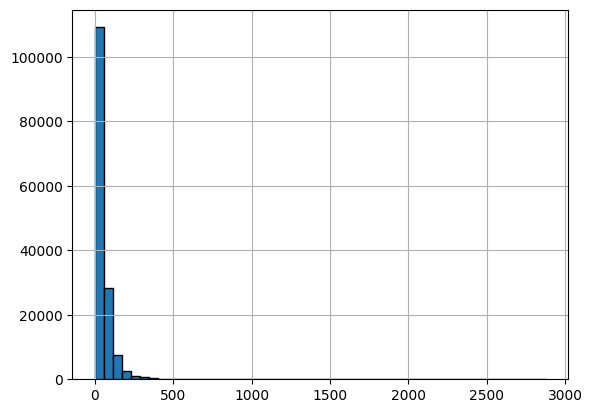

In [22]:
df.units_sold.hist(bins=50, edgecolor='black')
# thee is a outlier in the units_sold column

<Axes: xlabel='units_sold'>

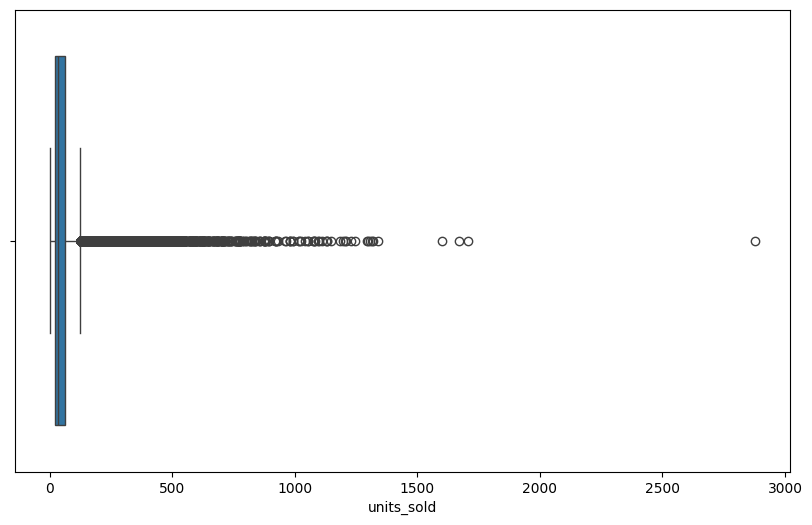

In [23]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['units_sold'])

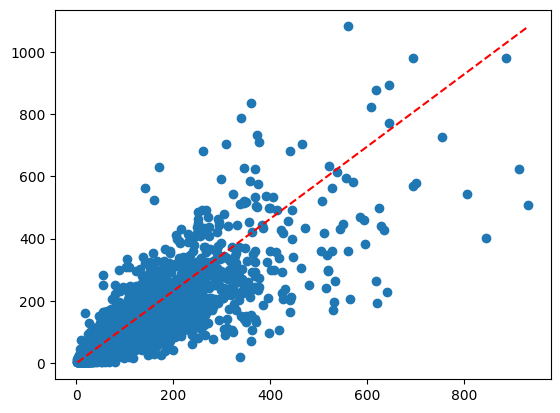

In [24]:
plt.scatter(y_pred, y_val)
plt.plot(np.linspace(y_pred.min(), y_pred.max()),np.linspace(y_val.min(), y_val.max()), color='red', linestyle='--')

array([[<Axes: title={'center': 'record_ID'}>,
        <Axes: title={'center': 'store_id'}>,
        <Axes: title={'center': 'sku_id'}>],
       [<Axes: title={'center': 'total_price'}>,
        <Axes: title={'center': 'base_price'}>,
        <Axes: title={'center': 'is_featured_sku'}>],
       [<Axes: title={'center': 'is_display_sku'}>,
        <Axes: title={'center': 'units_sold'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'year'}>, <Axes: >]], dtype=object)

<Figure size 1500x800 with 0 Axes>

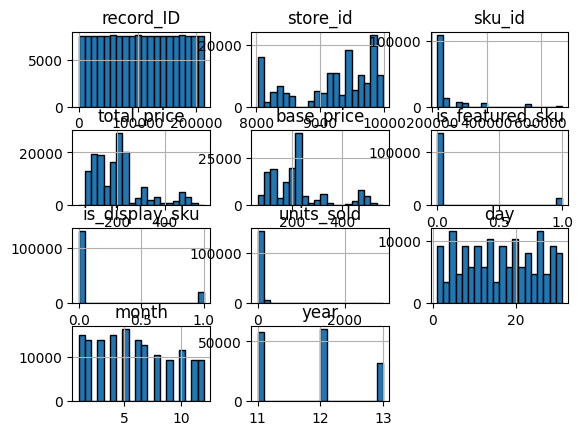

In [25]:
plt.figure(figsize=(15, 8))
df.hist(bins=20, edgecolor='black')

In [26]:
# we know that there are some outliers in the units_sold column, so we will remove them
# and also remove the record_ID
# also check sku_id, is_display_sku and maybe do a one-hot encoding 

# 4. Preprocesing

In [27]:
df = df.drop( columns= ['record_ID'])

In [28]:
dataframe_info(df).sort_values(by = 'Unique values', ascending=False)
# store_id 76 unique values and sku_id 28 unique values--> one hot encode

,Column_name,Total records,Missing Values,Data type,Unique values
6,units_sold,150150,0,int64,708
2,total_price,150150,0,float64,646
3,base_price,150150,0,float64,572
0,store_id,150150,0,int64,76
7,day,150150,0,int64,31
1,sku_id,150150,0,int64,28
8,month,150150,0,int64,12
9,year,150150,0,int64,3
5,is_display_sku,150150,0,int64,2
4,is_featured_sku,150150,0,int64,2


In [29]:
df = df[df['units_sold'] < df.units_sold.quantile(0.99)]

<Axes: >

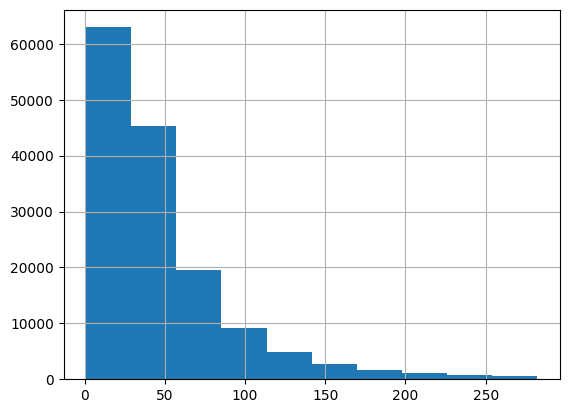

In [30]:
df.units_sold.hist()

In [31]:
pd.get_dummies(df,columns=['store_id','sku_id'],drop_first=True,dtype='int')
# it is ok becasue we have store_id 76 unique values and sku_id 28 unique values--> one hot encode

,total_price,base_price,is_featured_sku,is_display_sku,units_sold,day,month,year,store_id_8058,store_id_8063,...,sku_id_320485,sku_id_327492,sku_id_378934,sku_id_398721,sku_id_545621,sku_id_546789,sku_id_547934,sku_id_600934,sku_id_673209,sku_id_679023
0,99.0375,111.8625,0,0,20,17,1,11,0,0,...,0,0,0,0,0,0,0,0,0,0
1,99.0375,99.0375,0,0,28,17,1,11,0,0,...,0,0,0,0,0,0,0,0,0,0
2,133.9500,133.9500,0,0,19,17,1,11,0,0,...,0,0,0,0,0,0,0,0,0,0
3,133.9500,133.9500,0,0,44,17,1,11,0,0,...,0,0,0,0,0,0,0,0,0,0
4,141.0750,141.0750,0,0,52,17,1,11,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,235.8375,235.8375,0,0,38,9,7,13,0,0,...,0,0,0,0,0,0,0,0,0,0
150146,235.8375,235.8375,0,0,30,9,7,13,0,0,...,0,0,0,0,0,0,0,0,0,0
150147,357.6750,483.7875,1,1,31,9,7,13,0,0,...,0,0,0,0,0,0,0,0,0,0
150148,141.7875,191.6625,0,1,12,9,7,13,0,0,...,0,0,0,0,0,0,1,0,0,0


# 5. Train Model 2

In [32]:
X,y = df.drop(columns=['units_sold']), df['units_sold']

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [34]:
model2 = RandomForestRegressor(n_jobs=-1)
model2.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1)

In [35]:
y_preds2 = model2.predict(X_val)
rmse2 = root_mean_squared_error(y_val, y_preds2)
rmse2

19.565185170050746

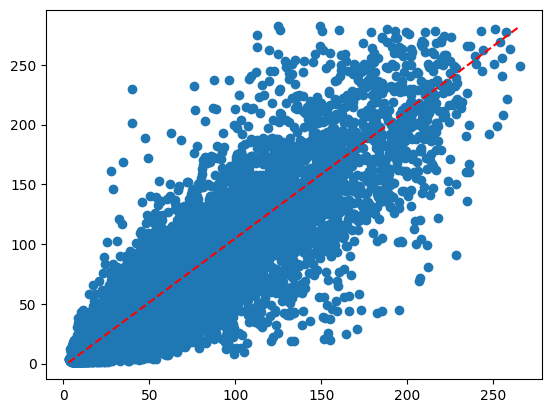

In [42]:
plt.scatter(y_preds2, y_val)
plt.plot(np.linspace(y_preds2.min(), y_preds2.max()),np.linspace(y_val.min(), y_val.max()), color='red', linestyle='--')

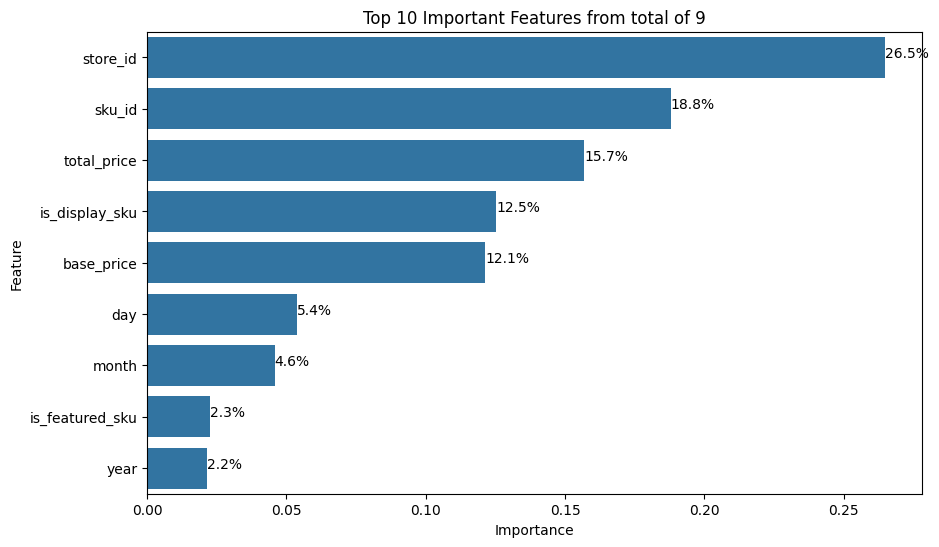

In [36]:
importances = model2.feature_importances_
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
plt.figure(figsize=(10, 6))
importances_df = importances_df.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=importances_df.head(10))

# data labels
for index, value in enumerate(importances_df['Importance'].head(10)):
    plt.text(value, index, f'{value*100:.1f}%')

plt.title(f'Top 10 Important Features from total of {len(importances_df)}')
plt.show()

# 6. Optuna Hyperparameter tunning

In [37]:
import optuna

In [ ]:
def objective(trial):
    paramters = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 601, step=50),
        'max_depth': trial.suggest_int('max_depth', 10, 61, step=5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 21, step=2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 21, step=2),
        'max_features': trial.suggest_categorical('max_features', [None,'sqrt', 'log2'])
    }

    model = RandomForestRegressor(**paramters,n_jobs= -1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

In [49]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=50, n_jobs=-1)

[I 2025-05-26 14:06:24,482] A new study created in memory with name: no-name-4962f8f6-c73b-4eda-8610-6ce9cec7748f
C:\Users\ondra\AppData\Roaming\Python\Python313\site-packages\optuna\distributions.py:699: UserWarning:

The distribution is specified by [100, 601] and step=50, but the range is not divisible by `step`. It will be replaced by [100, 600].

C:\Users\ondra\AppData\Roaming\Python\Python313\site-packages\optuna\distributions.py:699: UserWarning:

The distribution is specified by [10, 61] and step=5, but the range is not divisible by `step`. It will be replaced by [10, 60].

C:\Users\ondra\AppData\Roaming\Python\Python313\site-packages\optuna\distributions.py:699: UserWarning:

The distribution is specified by [2, 21] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 20].

C:\Users\ondra\AppData\Roaming\Python\Python313\site-packages\optuna\distributions.py:699: UserWarning:

The distribution is specified by [100, 601] and step=50, but the range is

In [50]:
print(study.best_params)
print(study.best_value)

{'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}
19.544614046467952


In [51]:
optuna.visualization.plot_optimization_history(study)

In [52]:
optuna.visualization.plot_parallel_coordinate(study)

In [54]:
def objective2(trial):
    paramters = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 301, step=50),
        'max_depth': trial.suggest_int('max_depth', 10, 61, step=5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 21, step=2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 21, step=2),
        'max_features': trial.suggest_categorical('max_features', [None,'sqrt', 'log2'])
    }

    model = RandomForestRegressor(**paramters,n_jobs= -1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

In [55]:
study2 = optuna.create_study(direction='minimize')
study2.optimize(objective2,n_trials=50, n_jobs=-1)

[I 2025-05-26 14:28:17,237] A new study created in memory with name: no-name-a98d6179-6e68-4804-843b-2934050bb3e3
C:\Users\ondra\AppData\Roaming\Python\Python313\site-packages\optuna\distributions.py:699: UserWarning:

The distribution is specified by [50, 301] and step=50, but the range is not divisible by `step`. It will be replaced by [50, 300].

C:\Users\ondra\AppData\Roaming\Python\Python313\site-packages\optuna\distributions.py:699: UserWarning:

The distribution is specified by [10, 61] and step=5, but the range is not divisible by `step`. It will be replaced by [10, 60].

C:\Users\ondra\AppData\Roaming\Python\Python313\site-packages\optuna\distributions.py:699: UserWarning:

The distribution is specified by [2, 21] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 20].

C:\Users\ondra\AppData\Roaming\Python\Python313\site-packages\optuna\distributions.py:699: UserWarning:

The distribution is specified by [50, 301] and step=50, but the range is no

In [56]:
print(study2.best_params)
print(study2.best_value)

{'n_estimators': 250, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}
19.466951708236678


# 7. Final Model


In [58]:
X = pd.concat([X_train,X_val])
y = pd.concat([y_train,y_val])

In [59]:
final_model = RandomForestRegressor(**study2.best_params, n_jobs = -1, random_state = 42)

In [60]:
final_model.fit(X,y)

RandomForestRegressor(max_depth=45, max_features=None, min_samples_split=4,
                      n_estimators=250, n_jobs=-1, random_state=42)

In [62]:
y_final_preds = final_model.predict(X_test)

In [63]:
rmse = root_mean_squared_error(y_test, y_final_preds)
print(f'Final RMSE: {rmse: 2f}')

Final RMSE:  18.645300


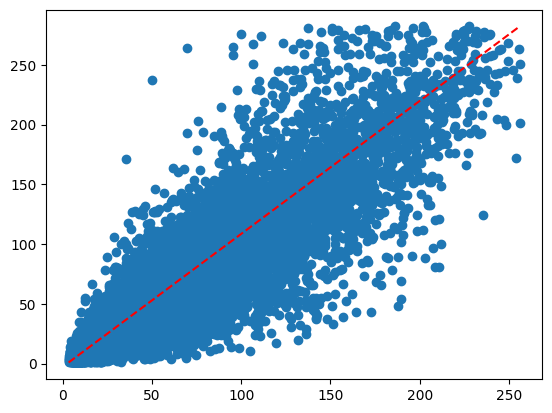

In [65]:
plt.scatter(y_final_preds, y_test)
plt.plot(np.linspace(y_final_preds.min(), y_final_preds.max()),np.linspace(y_test.min(), y_test.max()), color='red', linestyle='--')

In [66]:
importances = final_model.feature_importances_
df_importances = pd.DataFrame(
    {'Feature': X_test.columns,
     'Importances': importances}
)
df_importances = df_importances.sort_values( by = 'Importances', ascending= False)

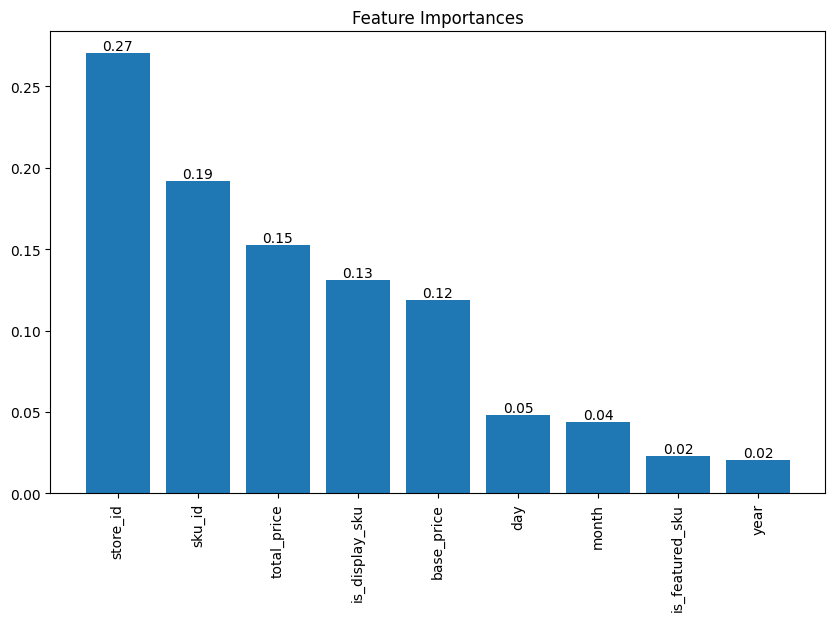

In [67]:
plt.figure(figsize=(10,6))
plt.bar(df_importances['Feature'], df_importances['Importances'])
plt.xticks(rotation=90)
plt.title('Feature Importances')
plt.bar_label(plt.gca().containers[0], fmt='%.2f')
plt.show()